In [23]:
from CryPy import *
import matplotlib
from CryPy.OSfunc import *
from CryPy.ExtractDiffusion import *
from CryPy.SignalProcessing import *
from main import ScData


a = ScData("01_1")

Preparing the folders for the results.
Current System Path Changed to : C:\Users\labadmin\Desktop\PythonCodes\CryPy\
Folder <01_1_DataOutPut> created.
                        name
0  Data\15x15x2_8_imagem.cam
Select your data by index :
analysing  15x15x2_8
mean background is = 2704.69
Background STD = 446.08


In [24]:
%matplotlib
a.take_molecules()


Using matplotlib backend: TkAgg
[83] [70]


In [25]:
a.add_mol_spec()



Plotting 1 molecules spectrum...
All molecules fluorescence trace saved in the CSV file.
 Data now contains the molecules ...


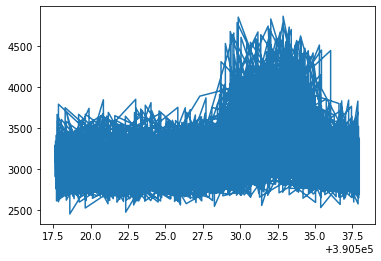

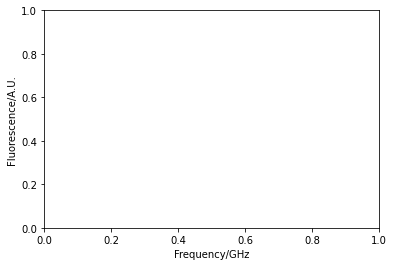

In [26]:
%matplotlib inline
a.plot_mols()
data = a.data.copy()

fitted_Dif_map(data) took 13.2 sec

In [38]:
from time import time


In [120]:
import matplotlib.pyplot as plt
from lmfit import Parameters, Model
import numpy as np
import pandas as pd

def lorentzian(f, f0, BG, FWHM, A:'Fluorescence Intensity'):
    a = FWHM ** 2 / 2
    L = BG + A * a / (a + (f - f0) ** 2)
    return L

def fit_Line(f, y, model, params):
    model = Model(lorentzian)
    result = model.fit(y, params, f=f)
    return result.params


def fitted_Dif_map(data, mol='mol0', df:'Frequency Resolution'=0.05, dt:"time resolution"=1, molname='__', mean_BG='3000'):
    data['f'] = (data.Frequency - data.Frequency.mean()) / 1e9
    log = pd.DataFrame(columns=["t","FWHM", "f0", "BG", "A"])
    fmin = data.f.min()
    fmax = data.f.max()

    tmin = data.t.min()
    tmax = data.t.max()
    f = np.arange(fmin, fmax + df, df)
    # t = np.arange(tmin, tmax + dt, dt)
    xpix = int((fmax - fmin) // df) +2
    ypix = int((tmax - tmin) // dt) +2
    dmap = np.zeros([xpix, ypix], dtype=float)
    print(xpix, 'x', ypix)

    model = Model(lorentzian)
    params = Parameters()
    params.add('A', value=1000)
    params.add("f0", value=3)
    params.add("FWHM", value=2, min=0.5, max=3)
    params.add('BG', value=int(mean_BG), min=0, max=20000)

    for n in range(ypix - 1):
        t = dt * n
        T = (data.t > t) & (data.t < t + dt)
        ldata = data[T]
        newParams = fit_Line(ldata.f, ldata.mol0, model, params)
        params = newParams.copy()
        A = newParams['A'].value
        BG = newParams['BG'].value
        fwhm = newParams['FWHM'].value
        f0 = newParams['f0'].value

        log = log.append({"t":t , "FWHM" : fwhm, "BG": BG, "f0" : f0, "A": A}, ignore_index=True)

        newParams['A'].value = 1  # normalizing each line. the intensity does not matter this way
        newParams['BG'].value = 0
        dmap[:, n] = model.eval(newParams, f=f)



    f, t = np.mgrid[slice(fmin, fmax + df, df), slice(tmin, tmax + dt, dt)]

    fig, axs = plt.subplots(1, 1 , figsize=(1,2))
    ax = axs
    c = ax.pcolor(f, t, dmap, cmap='viridis', vmin=0, vmax=1)
    ax.set_title('Spectral Diffusion')
    ax.set_xlabel('$\Delta f$  (GHz)')
    ax.set_ylabel('Time (s)')
    fig.colorbar(c, ax=ax)
    plt.show()
    return log

In [122]:
%matplotlib
t0 = time()
log = fitted_Dif_map(data)
print("the process took {:.2f} sec".format(time()-t0))

Using matplotlib backend: TkAgg
409 x 213
the process took 13.28 sec


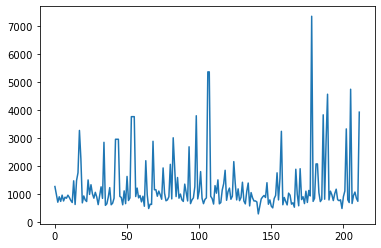

In [112]:
plt.plot(log.t,log.A)